In [1]:
# Import Dependencies
import pandas as pd
from sqlalchemy import create_engine
import datetime
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

# import nltk
# from nltk.corpus import stopwords
# import re
# import networkx
# from textblob import TextBlob

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Create engine 
engine = create_engine("sqlite:///data/hashtag2020.db", echo=True)
conn = engine.connect()

2021-02-10 15:57:59,815 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2021-02-10 15:57:59,817 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:57:59,823 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2021-02-10 15:57:59,824 INFO sqlalchemy.engine.base.Engine ()


In [3]:
#Create the table. If we use automap_base, the table must have a primary key
conn.execute("""
    CREATE TABLE IF NOT EXISTS tweet_counts (
        id integer PRIMARY KEY,
        created_at TEXT,
        tweet VARCHAR(280),
        likes integer,
        retweet_count integer,
        source VARCHAR(30),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Date TEXT,
        Time TEXT,
        polarity integer,
        analysis VARCHAR(20)
        
    )
""")

2021-02-10 15:57:59,845 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS tweet_counts (
        id integer PRIMARY KEY,
        created_at TEXT,
        tweet VARCHAR(280),
        likes integer,
        retweet_count integer,
        source VARCHAR(30),
        lat integer,
        long integer,
        city VARCHAR(100),
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Date TEXT,
        Time TEXT,
        polarity integer,
        analysis VARCHAR(20)
        
    )

2021-02-10 15:57:59,849 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:57:59,853 INFO sqlalchemy.engine.base.Engine COMMIT


In [4]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS sent_avg (
        avg_id integer PRIMARY KEY,
        city VARCHAR(100),
        lat integer,
        long integer,
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Pol_Avg integer,
        analysis VARCHAR(20)
   
    )
""")

2021-02-10 15:58:00,909 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS sent_avg (
        avg_id integer PRIMARY KEY,
        city VARCHAR(100),
        lat integer,
        long integer,
        state_code VARCHAR(5),
        hashtag VARCHAR(10),
        Pol_Avg integer,
        analysis VARCHAR(20)
   
    )

2021-02-10 15:58:00,910 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:58:00,921 INFO sqlalchemy.engine.base.Engine COMMIT


In [5]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS sent_count (
        count_id integer PRIMARY KEY,
        hashtag VARCHAR(10),
        analysis VARCHAR(20),
        count integer
        
    )
""")

2021-02-10 15:58:01,656 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS sent_count (
        count_id integer PRIMARY KEY,
        hashtag VARCHAR(10),
        analysis VARCHAR(20),
        count integer
        
    )

2021-02-10 15:58:01,657 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:58:01,658 INFO sqlalchemy.engine.base.Engine COMMIT


In [6]:
conn.execute("""
    CREATE TABLE IF NOT EXISTS tweet_time (
        id integer PRIMARY KEY,
        created_at TEXT,
        trump integer,
        biden integer
        
    )
""")

2021-02-10 15:58:02,354 INFO sqlalchemy.engine.base.Engine 
    CREATE TABLE IF NOT EXISTS tweet_time (
        id integer PRIMARY KEY,
        created_at TEXT,
        trump integer,
        biden integer
        
    )

2021-02-10 15:58:02,355 INFO sqlalchemy.engine.base.Engine ()
2021-02-10 15:58:02,357 INFO sqlalchemy.engine.base.Engine COMMIT


In [7]:
# Read in CSV's and build initial combined dataframe
trump_csv_path = "../hashtag_donaldtrump.csv"
biden_csv_path = "../hashtag_joebiden.csv"

In [8]:
trump_data_df = pd.read_csv(trump_csv_path, lineterminator='\n')
biden_data_df = pd.read_csv(biden_csv_path, lineterminator='\n')

In [9]:
trump_data_df["hashtag"]="Trump"
biden_data_df["hashtag"]="Biden"

In [10]:
tweet_df = pd.concat([trump_data_df, biden_data_df])

In [ ]:
tweet_df["created_at"]=pd.to_datetime(tweet_df.created_at)

In [ ]:
tweet_df.sort_values(by = 'created_at')

In [ ]:
usa = {"United States of America" : "United States"}
tweet_df['country'].replace(usa, inplace=True)

In [ ]:
clean_df = tweet_df.dropna(how='any')

In [ ]:
# Filter to data for United States only
clean_df = clean_df.loc[clean_df['country']== 'United States']

In [ ]:
print("Count of duplicates: {}".format(clean_df.duplicated(subset=["tweet"]).sum()))

In [ ]:
# Remove duplicate tweets, leaving only those with either hashtag not both
print("Original size of df: {}".format(len(clean_df)))
clean_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(clean_df)))

In [ ]:
clean_df.reset_index(inplace=True)

In [ ]:
clean_df['Date'] = clean_df['created_at'].dt.strftime('%m/%d/%Y')
clean_df['Time'] = clean_df['created_at'].dt.strftime('%H:%M:%S')

In [ ]:
# Setting id column to use as primary key
clean_df = clean_df.rename(columns = {'index': 'id'}, inplace = False)

In [ ]:
clean_df = clean_df[['id', 'created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time']]

In [ ]:
clean_df = clean_df[['created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time']]

In [ ]:
clean_df.reset_index(inplace=True)

In [ ]:
clean_df = clean_df.rename(columns = {'index': 'id'}, inplace = False)
clean_df.head()

In [ ]:
clean_df['id'].value_counts()

In [ ]:
# Sentiment Analysis - code created by Try Suharso https://www.kaggle.com/trysuharso (2020) Pandas, NLTK, Re, TextBlob, Networkx. [Source code]. https://www.kaggle.com/trysuharso/us-election-2020-twitter-analysis

In [ ]:
#cleaning the tweets
def clean_tweets(tweet):
 
    tweet = re.sub(r':', '', str(tweet))
    tweet = re.sub(r'‚Ä¶', '', str(tweet))
    tweet = re.sub('@[A-Za-z0–9]+', '', str(tweet))               
    tweet = re.sub('#', '', str(tweet)) # Removing '#' hash tag
    tweet = re.sub('https?:\/\/\S+', '', str(tweet)) # Removing hyperlink
    #replace consecutive non-ASCII characters with a space
    tweet = re.sub(r'[^\x00-\x7F]+',' ',str(tweet))
    tweet = str(tweet).lower()
    tweet = re.sub('\[.*?\]', '', tweet)
    tweet = re.sub('https?://\S+|www\.\S+', '', tweet)
    tweet = re.sub('<.*?>+', '', tweet)
    tweet = re.sub('\n', '', tweet)
    tweet = re.sub('\w*\d\w*', '', tweet)
    tweet = re.sub(r'#','',tweet)
    tweet = re.sub(r'RT[\s]+','',tweet)
    tweet = re.sub(r'[^\w]', ' ', tweet)
    tweet = re.sub('https', '', tweet)
    tweet = re.sub('https ', '', tweet)
    tweet = re.sub('co', '', tweet)

    return tweet

In [ ]:
# Determine subjectivity, polarity, sentiment values of each tweet 
# ALLOW SEVERAL MINUTES TO COMPLETE
def getSubjectivity(tweet):
    try:
        return TextBlob(tweet).sentiment.subjectivity
    except:
        return None


# Create a function to get the polarity
def getPolarity(tweet):
    try:
        return  TextBlob(tweet).sentiment.polarity
    except:
        return None

def sentiment_calc(tweet):
    try:
        return TextBlob(tweet).sentiment
    except:
        return None

# Add sentiment analysis value columns to df
clean_df['edited_tweet'] = clean_df['tweet'].apply(clean_tweets)
clean_df['subjectivity'] = clean_df['edited_tweet'].apply(getSubjectivity)
clean_df['polarity'] = clean_df['edited_tweet'].apply(getPolarity)
clean_df['sentiment'] = clean_df['edited_tweet'].apply(sentiment_calc)

# Assign sentiment analysis category based on polarity value and add to df
def getAnalysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'

clean_df['analysis'] = clean_df['polarity'].apply(getAnalysis)

In [ ]:
clean_df.head()

In [ ]:
# Creating dataframe for polarity average by city location for map visual
biden=clean_df[clean_df['hashtag']=='Biden']
trump=clean_df[clean_df['hashtag']=='Trump']

In [ ]:
biden['Pol_Avg'] = biden.groupby('city').polarity.transform('mean')
trump['Pol_Avg'] = trump.groupby('city').polarity.transform('mean')


In [ ]:
biden = biden[['city','lat', 'long', 'state_code', 'hashtag','Pol_Avg' ]]
trump = trump[['city','lat', 'long','state_code', 'hashtag','Pol_Avg' ]]

In [ ]:
biden = biden.drop_duplicates(subset=['city'], keep='first')
trump = trump.drop_duplicates(subset=['city'], keep='first')

In [ ]:
biden['analysis'] = biden['Pol_Avg'].apply(getAnalysis)
trump['analysis'] = trump['Pol_Avg'].apply(getAnalysis)

In [ ]:
biden['analysis'].value_counts()

In [ ]:
trump['analysis'].value_counts()

In [ ]:
sent_avg = pd.concat([biden, trump])
sent_avg = sent_avg.reset_index(drop=True)

In [ ]:
sent_avg.reset_index(inplace=True)
sent_avg = sent_avg.rename(columns = {'index': 'avg_id'}, inplace = False)

In [ ]:
sent_avg.head()

In [ ]:
# Creating dataframe for sentiment counts bar visual
biden_count=clean_df[clean_df['hashtag']=='Biden']
trump_count=clean_df[clean_df['hashtag']=='Trump']


In [ ]:
biden_count = biden_count[['analysis', 'hashtag']]
trump_count = trump_count[['analysis', 'hashtag']]

In [ ]:
biden_count["count"]=1
trump_count["count"]=1

In [ ]:
biden_count = biden_count.groupby('analysis').count().reset_index()
trump_count = trump_count.groupby('analysis').count().reset_index()

In [ ]:
biden_count['hashtag']="Biden"
trump_count['hashtag']="Trump"

In [ ]:
sent_count = pd.concat([biden_count, trump_count])
sent_count = sent_count.reset_index(drop=True)

In [ ]:
sent_count.reset_index(inplace=True)
sent_count = sent_count.rename(columns = {'index': 'count_id'}, inplace = False)

In [ ]:
sent_count

In [ ]:
clean_df = clean_df[['id', 'created_at', 'tweet', 'likes', 'retweet_count', 'source', 'lat', 'long', 'city','state_code','hashtag', 'Date', 'Time', 'polarity', 'analysis']]

In [ ]:
clean_df.head()

In [ ]:
clean_df.to_sql("tweet_counts", conn, if_exists="append", index=False)


In [ ]:
sent_avg.to_sql("sent_avg", conn, if_exists="append", index=False)

In [ ]:
sent_count.to_sql("sent_count", conn, if_exists="append", index=False)

# Buckley's Code

In [11]:
trump_data_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",...,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",...,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970915,2020-11-08 23:59:48,1.325589e+18,JOE BIDEN WHY JOE BIDEN DID WINNED ?? TRUMP TR...,4.0,0.0,Twitter Web App,3.245258e+09,ahzy,ahhhzy,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.715870,Trump
970916,2020-11-08 23:59:53,1.325589e+18,#AfD|ler reagieren panisch bis hysterisch auf ...,25.0,4.0,Twitter Web App,9.866108e+17,watchdog,wilke_tobias,Quis custodiet ipsos custodes?\n\nTV Journalis...,...,Saxony/GER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.975868,Trump
970917,2020-11-08 23:59:54,1.325589e+18,"@sammelbis1998 @iheartmindy @bnorthg First, yo...",0.0,0.0,Twitter for iPad,7.687811e+08,Debra,drdeblk,MD. Autism specialist. Film lover. #DumpTrump2020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:56.012674,Trump
970918,2020-11-08 23:59:55,1.325589e+18,OK just had to do it !\n#Trump #CatapultTrump ...,105.0,28.0,Twitter Web App,4.519791e+08,Dunken K Bliths,DunkenKBliths,"""Tesla owner's will be followed back""\n\n#Mach...",...,✔ Official Twitter Account,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 17:47:55.807500,Trump


In [12]:
biden_data_df.sort_values(by = 'created_at')

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,...,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Biden
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,Biden
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,...,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,Biden
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849,Biden
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,...,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,Biden
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776882,2020-11-08 23:59:38,1.325589e+18,Ωχ ελπίζω να μη μας βγει σαν τους οπαδούς του...,0.0,0.0,Twitter for Android,4.032819e+08,οχι άλλο κάρβουνο 🇬🇷🗣🗣🗣,anapodoi,ακραία καιρικά φαινόμενα... ζήσαμε και απόψε,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.947617,Biden
776883,2020-11-08 23:59:41,1.325589e+18,L'OTAN va sortir de sa léthargie et redevenir ...,48.0,14.0,Twitter for Android,7.819183e+17,🇫🇷 Alt-Droite (matricule 6921) ✝️ 🇬🇷 🇮🇹 🇦🇲,CtrlAltDroite,Fils de mineur. Libertés - Identité - Solidari...,...,France,46.603354,1.888334,NaN,France,Europe,NaN,NaN,2020-11-09 18:32:45.627335,Biden
776884,2020-11-08 23:59:52,1.325589e+18,🌎\n\n“#congiuntifuoriregione”\n\n‘Sono felice ...,1.0,1.0,Twitter for iPhone,5.293315e+08,Angelo Tani,AngeloTani,nato a casa dei nonni,...,🌎,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-11-09 18:32:45.599846,Biden
737089,2020-11-08 23:59:57,1.325589e+18,#JoeBiden 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 https://t.co/Ym...,0.0,0.0,Twitter for iPhone,1.148479e+08,Nataša,PewPeeew,My brain consists of coping mechanisms and vin...,...,Deutschland,51.083420,10.423447,NaN,Germany,Europe,NaN,NaN,2020-11-09 18:26:04.550843,Biden


In [13]:
usa = {"United States of America" : "United States"}
trump_data_df['country'].replace(usa, inplace=True)
biden_data_df['country'].replace(usa, inplace=True)

In [14]:
trump_data_df = trump_data_df.dropna(how='any')
biden_data_df = biden_data_df.dropna(how='any')

In [15]:
trump_data_df = trump_data_df.loc[trump_data_df['country']== 'United States']
biden_data_df = biden_data_df.loc[biden_data_df['country']== 'United States']

In [16]:
print("Count of duplicates: {}".format(trump_data_df.duplicated(subset=["tweet"]).sum()))
print("Count of duplicates: {}".format(biden_data_df.duplicated(subset=["tweet"]).sum()))

Count of duplicates: 1421
Count of duplicates: 807


In [17]:
print("Original size of df: {}".format(len(trump_data_df)))
trump_data_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(trump_data_df)))

print("Original size of df: {}".format(len(biden_data_df)))
biden_data_df.drop_duplicates(subset=["tweet"], inplace=True, keep=False)
print("No duplicates size of df : {}".format(len(biden_data_df)))

Original size of df: 96623
No duplicates size of df : 94581
Original size of df: 85761
No duplicates size of df : 84461


In [18]:
trump_data_df.reset_index(inplace=True)
biden_data_df.reset_index(inplace=True)

In [19]:
trump_data_df.head(3)

,index,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [20]:
# trump_data_df['Date'] = trump_data_df['created_at'].dt.strftime('%m/%d/%Y')
# biden_data_df['Time'] = biden_data_df['created_at'].dt.strftime('%H:%M:%S')

In [21]:
trump_data_df = trump_data_df.rename(columns = {'index': 'id'}, inplace = False)
trump_data_df.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [22]:
biden_data_df = biden_data_df.rename(columns = {'index': 'id'}, inplace = False)
biden_data_df.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:03.106963698,Biden
1,17,2020-10-15 00:01:23,1.316530e+18,"Comments on this? ""Do Democrats Understand how...",0.0,0.0,Twitter Web App,1.016593e+08,John Ubaldi,ubaldireports,...,"Tampa, Florida",27.947760,-82.458444,Tampa,United States,North America,Florida,FL,2020-10-21 00:00:08.803063811,Biden
2,25,2020-10-15 00:01:57,1.316530e+18,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,Twitter for Android,1.300837e+18,Sam KEYS,SamKEYS65729181,...,"Los Angeles, CA",34.053691,-118.242766,Los Angeles,United States,North America,California,CA,2020-10-21 00:00:12.945682075,Biden


In [23]:
t_time_series = pd.Series(1, index=trump_data_df['created_at'])
t_time_series.head(3)

created_at
2020-10-15 00:00:02    1
2020-10-15 00:00:08    1
2020-10-15 00:00:25    1
dtype: int64

In [24]:
b_time_series = pd.Series(1, index=biden_data_df['created_at'])
b_time_series.head(3)

created_at
2020-10-15 00:00:25    1
2020-10-15 00:01:23    1
2020-10-15 00:01:57    1
dtype: int64

In [25]:
# Converting the index as date
t_time_series.index = pd.to_datetime(t_time_series.index)
trump_df = t_time_series.resample('12H').sum()
trump_df.head(3)

created_at
2020-10-15 00:00:00    1063
2020-10-15 12:00:00    1535
2020-10-16 00:00:00    1912
Freq: 12H, dtype: int64

In [26]:
b_time_series.index = pd.to_datetime(b_time_series.index)
biden_df = b_time_series.resample('12H').sum()
biden_df.head(3)

created_at
2020-10-15 00:00:00     814
2020-10-15 12:00:00    1239
2020-10-16 00:00:00    1601
Freq: 12H, dtype: int64

In [27]:
t_time_series_df = pd.DataFrame(trump_df)
t_time_series_df.head()

,0
created_at,
2020-10-15 00:00:00,1063
2020-10-15 12:00:00,1535
2020-10-16 00:00:00,1912
2020-10-16 12:00:00,1958
2020-10-17 00:00:00,874


In [28]:
b_time_series_df = pd.DataFrame(biden_df)
b_time_series_df.head()

,0
created_at,
2020-10-15 00:00:00,814
2020-10-15 12:00:00,1239
2020-10-16 00:00:00,1601
2020-10-16 12:00:00,1366
2020-10-17 00:00:00,612


In [29]:
combined_df = pd.concat([t_time_series_df, b_time_series_df], axis=1, join="inner")
combined_df.head()

,0,0
created_at,,
2020-10-15 00:00:00,1063,814
2020-10-15 12:00:00,1535,1239
2020-10-16 00:00:00,1912,1601
2020-10-16 12:00:00,1958,1366
2020-10-17 00:00:00,874,612


In [30]:
combined_df.columns = ['trump', 'biden']
combined_df.head(3)

,trump,biden
created_at,,
2020-10-15 00:00:00,1063,814
2020-10-15 12:00:00,1535,1239
2020-10-16 00:00:00,1912,1601


Text(0, 0.5, 'Number of Tweets')

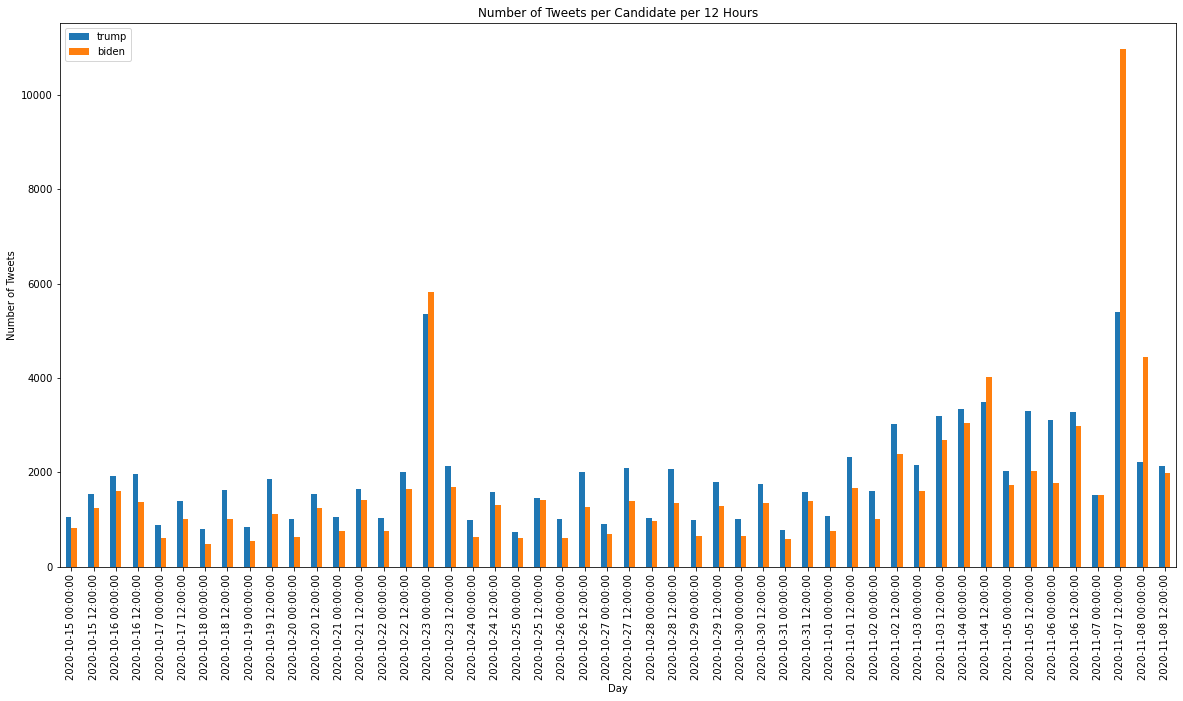

In [31]:
#Plotting bar graph to show how many tweets by day
combined_df.plot(kind='bar', title='Number of Tweets per Candidate per 12 Hours', figsize=(20,10), width = 0.5)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')

In [32]:
biden_st=biden_data_df[biden_data_df['hashtag']=='Biden']
biden_st.head(3)


,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,6,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,1.994033e+07,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:03.106963698,Biden
1,17,2020-10-15 00:01:23,1.316530e+18,"Comments on this? ""Do Democrats Understand how...",0.0,0.0,Twitter Web App,1.016593e+08,John Ubaldi,ubaldireports,...,"Tampa, Florida",27.947760,-82.458444,Tampa,United States,North America,Florida,FL,2020-10-21 00:00:08.803063811,Biden
2,25,2020-10-15 00:01:57,1.316530e+18,@RealJamesWoods #BidenCrimeFamily #JoeBiden #H...,0.0,0.0,Twitter for Android,1.300837e+18,Sam KEYS,SamKEYS65729181,...,"Los Angeles, CA",34.053691,-118.242766,Los Angeles,United States,North America,California,CA,2020-10-21 00:00:12.945682075,Biden


In [33]:
trump_st=trump_data_df[trump_data_df['hashtag']=='Trump']
trump_st.head(3)

,id,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,...,user_location,lat,long,city,country,continent,state,state_code,collected_at,hashtag
0,2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,...,Portland,45.520247,-122.674195,Portland,United States,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
1,4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,...,Washington DC,38.894992,-77.036558,Washington,United States,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump
2,11,2020-10-15 00:00:25,1.316529e+18,"In 2020, #NYPost is being #censorship #CENSORE...",0.0,0.0,Twitter for iPhone,19940334.0,Change Illinois | Biden will increase taxes by...,changeillinois,...,"Chicago, Illinois",41.875562,-87.624421,Chicago,United States,North America,Illinois,IL,2020-10-21 00:00:04.105381834,Trump


In [34]:
biden_st_df = biden_st[['state_code', 'hashtag','created_at']]
trump_st_df = trump_st[['state_code', 'hashtag','created_at']]

In [39]:
biden_st_series = pd.Series(1, index=biden_st_df['state_code'])
biden_st_series.head(3)

state_code
IL    1
FL    1
CA    1
dtype: int64

In [40]:
trump_st_series = pd.Series(1, index=trump_st_df['state_code'])
trump_st_series.head(3)

state_code
OR    1
DC    1
IL    1
dtype: int64

In [41]:
biden_st_df = pd.DataFrame(biden_st_series)
biden_st_df.head()

,0
state_code,
IL,1
FL,1
CA,1
NY,1
MN,1


In [51]:
biden_st_df.columns = ['biden']
biden_st_df.head(3)

,biden
state_code,
IL,1
FL,1
CA,1


In [55]:
biden_count = biden_st_df.groupby('state_code')['biden'].value_counts()
biden_count.head(3)

state_code  biden
AK          1        121
AL          1        275
AR          1         66
Name: biden, dtype: int64

In [44]:
trump_st_df = pd.DataFrame(trump_st_series)
trump_st_df.head()

,0
state_code,
OR,1
DC,1
IL,1
CA,1
OR,1


In [58]:
trump_st_df.columns = ['trump']
trump_st_df.head(3)

,trump
state_code,
OR,1
DC,1
IL,1


In [60]:
trump_count = trump_st_df.groupby('state_code')['trump'].value_counts()
trump_count.head(3)

state_code  trump
AK          1         87
AL          1        293
AR          1         68
Name: trump, dtype: int64

In [62]:
combined_count_df = pd.concat([trump_count, biden_count], axis=1, join="inner")
combined_count_df.head()

,,trump,biden
AK,1,87,121
AL,1,293,275
AR,1,68,66
AZ,1,1600,1728
CA,1,18103,15838


Text(0, 0.5, 'Number of Tweets')

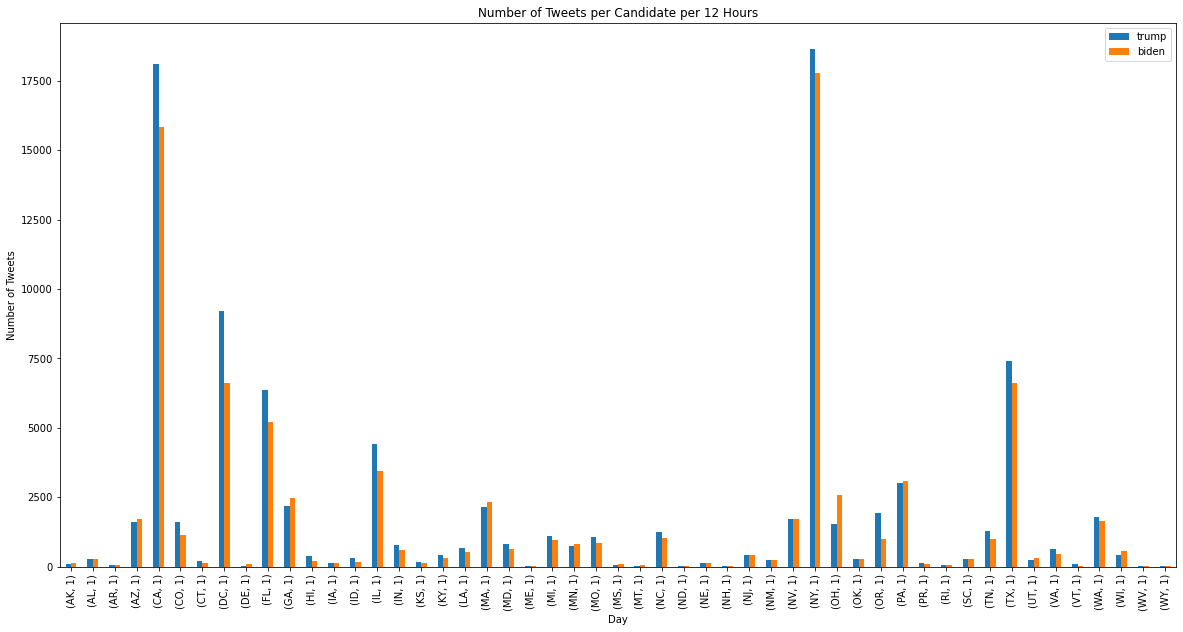

In [63]:
#Plotting bar graph to show how many tweets by day
combined_count_df.plot(kind='bar', title='Number of Tweets per Candidate per 12 Hours', figsize=(20,10), width = 0.5)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')

In [ ]:
# trump_st_series.index = pd.to_datetime(trump_st_series.index)
# trump_df = trump_st_series.resample('D').value_counts()
# trump_df.head(3)

In [ ]:
# biden_st_series.index = pd.to_datetime(biden_st_series.index)
# biden_df = biden_st_series.resample('12H').sum()
# biden_df.head(3)

In [ ]:
biden_st_series = pd.DataFrame(biden_df)
biden_st_series.head()

In [ ]:
t_st_df = pd.DataFrame(trump_df)
t_st_df.head()

In [ ]:
combined_st_df = pd.concat([t_st_df, b_st_df], axis=1, join="inner")
combined_st_df.head()

In [ ]:
combined_st_df.columns = ['Trump', 'Biden']
combined_st_df.head(3)

In [ ]:
# biden_stcode_df = biden_st[['state_code']]
# trump_stcode_df = trump_st[['state_code']]

In [ ]:
# b_t_combined = pd.concat([biden_stcode_df, trump_stcode_df], axis=1, join="inner")
# b_t_combined.head()

In [ ]:
# combined_t_st_df = pd.concat([combined_st_df, b_t_combined], axis=1)
# combined_t_st_df.head(3)

In [ ]:
#Plotting bar graph to show how many tweets by day
combined_st_df.plot(kind='bar', title='Number of Tweets per Candidate per 12 Hours', figsize=(20,10), width = 0.5)
plt.xlabel('Day')
plt.ylabel('Number of Tweets')

In [ ]:
import plotly.graph_objs as go

In [ ]:
trace1 = go.Bar(
        x = df_new['created_at'],
        y = df_new['trump'],
        name = 'trump')

trace2 = go.Bar(
        x = df_new['created_at'],
        y = df_new['biden'],
        name = 'biden')

In [ ]:
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
init_notebook_mode(connected=True)

In [ ]:
data = [trace1, trace2]
layout = go.Layout(barmode='group')

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='grouped-bar')